# 目次

- データ確認
- 目的変数との関係性を可視化
- データ準備
- ADF検定処理
  1. 差分変換
  2. 対数変換
  3. 対数差分変換
  4. 季節差分変換
  5. ラグ１の差分を取る
- 周期性の確認
  1. 成分分解
  2. コレログラム
- 前処理後のデータで再確認

# ライブラリ群

In [5]:
# データ処理
import csv
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

# 評価
from sklearn import metrics

# 描画
import matplotlib.pyplot as plt
import matplotlib.style as mplstyle
import japanize_matplotlib
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style(style='dark')
from tqdm import tqdm # プログレスバー
mplstyle.use('fast')

# 表示調整
from matplotlib import rcParams
# スタイル・フォントの調整
plt.style.use('ggplot') 
font = {'family' : 'meiryo'}
plt.rc('font', **font)
rcParams['font.family'] = 'sans-serif'
# 日本語対応
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']
plt.rcParams["figure.figsize"] = [20,5] # 表示サイズ
plt.rcParams["font.size"] = 10 # 文字サイズ
# HTML対応
from IPython.core.display import display, HTML
# 全表示対応
display(HTML("<style>.cm-s-ipython span.cm-comment { color: blue; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

# データ確認

In [6]:
stock_df = pd.read_csv("./Tesla.csv")

In [7]:
stock_df.shape
stock_df.head().astype(str)
stock_df.tail().astype(str)

(1692, 7)

Date       Open   High        Low      Close    Volume  Adj_Close
0  6/29/2010       19.0   25.0  17.540001  23.889999  18766300  23.889999
1  6/30/2010  25.790001  30.42  23.299999      23.83  17187100      23.83
2   7/1/2010       25.0  25.92      20.27  21.959999   8218800  21.959999
3   7/2/2010       23.0   23.1  18.709999  19.200001   5139800  19.200001
4   7/6/2010       20.0   20.0      15.83  16.110001   6866900  16.110001

Date                Open        High                 Low  \
1687  3/13/2017  244.82000699999998  246.850006  242.77999900000003   
1688  3/14/2017  246.11000099999998  258.119995          246.020004   
1689  3/15/2017               257.0       261.0          254.270004   
1690  3/16/2017          262.399994      265.75          259.059998   
1691  3/17/2017               264.0  265.329987          261.200012   

           Close   Volume   Adj_Close  
1687  246.169998  3010700  246.169998  
1688       258.0  7575500       258.0  
1689  255.729996  4816600  255.729996  
1690  262.049988  7100400  262.049988  
1691       261.5  6475900       261.5

In [8]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1692 entries, 0 to 1691
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1692 non-null   object 
 1   Open       1692 non-null   float64
 2   High       1692 non-null   float64
 3   Low        1692 non-null   float64
 4   Close      1692 non-null   float64
 5   Volume     1692 non-null   int64  
 6   Adj_Close  1692 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 92.7+ KB


In [9]:
# 欠損値
missing_values = pd.DataFrame()
for column in stock_df.columns:
    missing_values[column] = [stock_df[stock_df[column].isnull()].shape[0]]
missing_values.T.head()

0
Date   0
Open   0
High   0
Low    0
Close  0

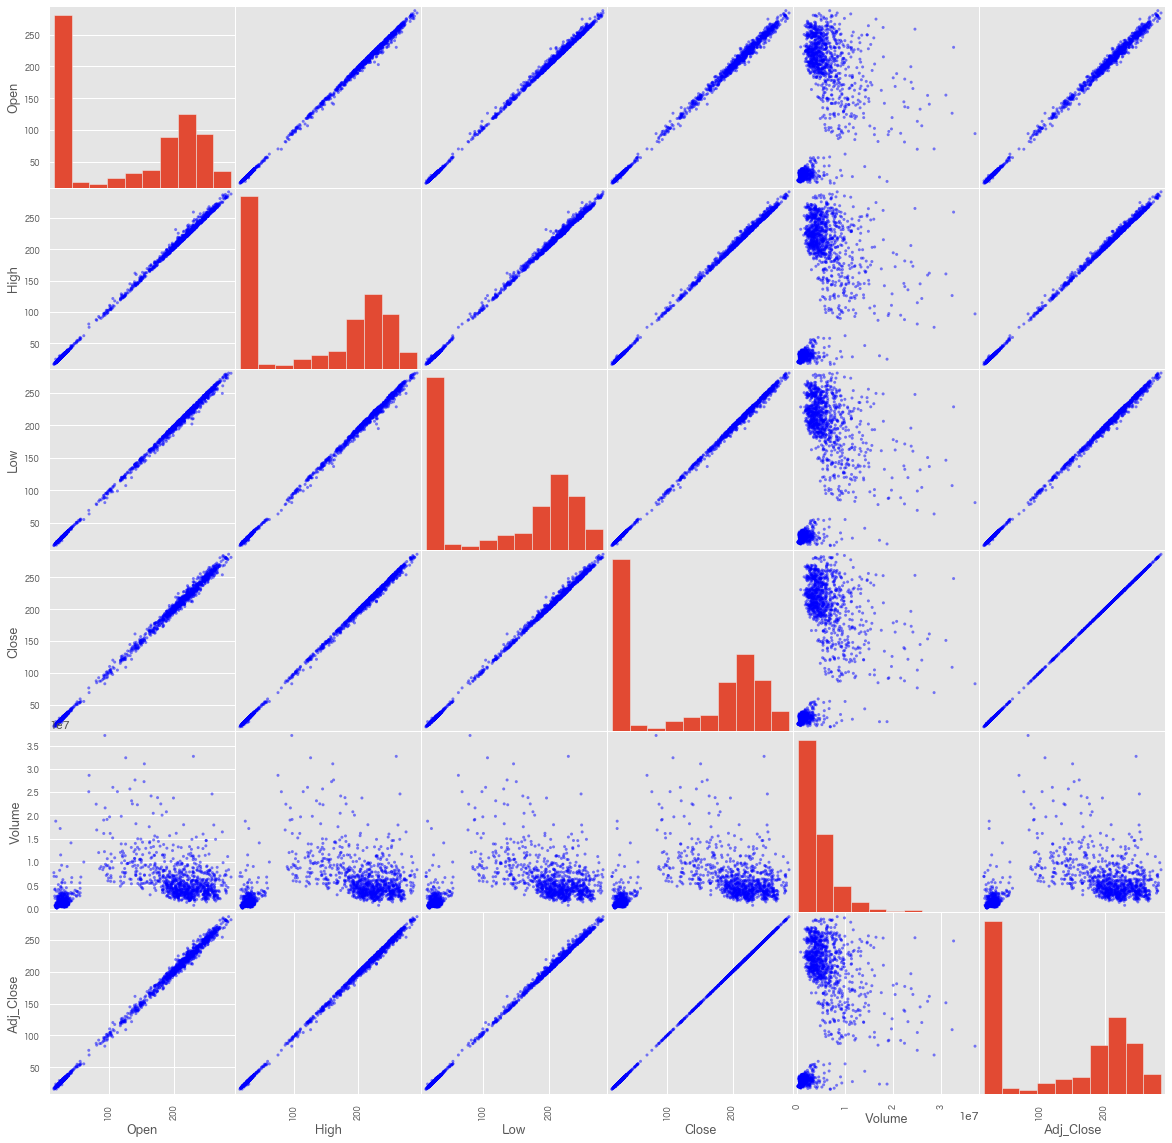

In [10]:
# 散布図行列
# 外れ値
pd.plotting.scatter_matrix(stock_df, c='blue', figsize=(20, 20))
plt.show();

線形の相関のある項目が非常に多い。  
単一の各特徴量の分布も、非常に近似している。  

# 目的変数との関係性を可視化

In [11]:
def target_relation(tgt, data):
    y_train = data[tgt]

    # ヒートマップの表示数
    k = len(data.columns) - 1
    fig = plt.figure(figsize=(20,20))

    # 各変数間の相関係数
    corrmat = data.corr()

    # リストの最大値から順にk個の要素を取得
    cols = corrmat.nlargest(k, tgt)[tgt].index

    # 全て可視化
    for i in np.arange(1, k):
        X_train = data[cols[i]]
        ax = fig.add_subplot(5,4, i)
        sns.regplot(x=X_train, y=y_train)
    
    plt.tight_layout()
    plt.show();

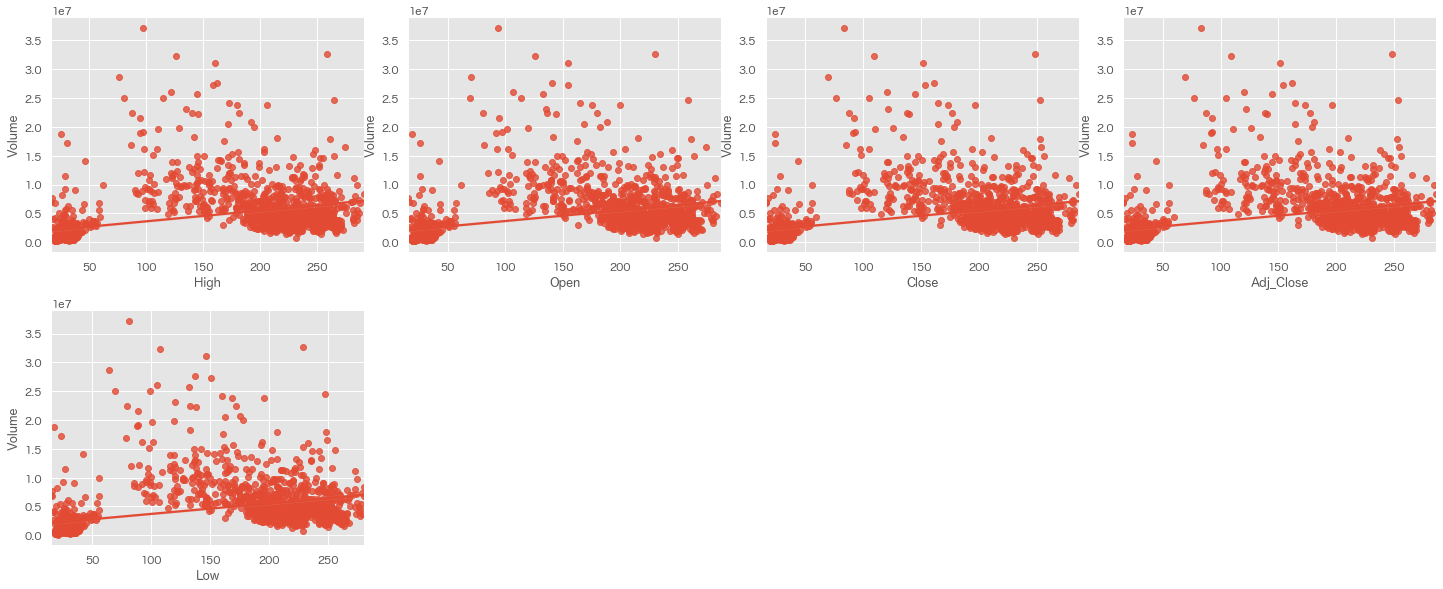

In [12]:
tgt = 'Volume' # 目的変数（取引量とした場合）
data = stock_df
target_relation(tgt, data)

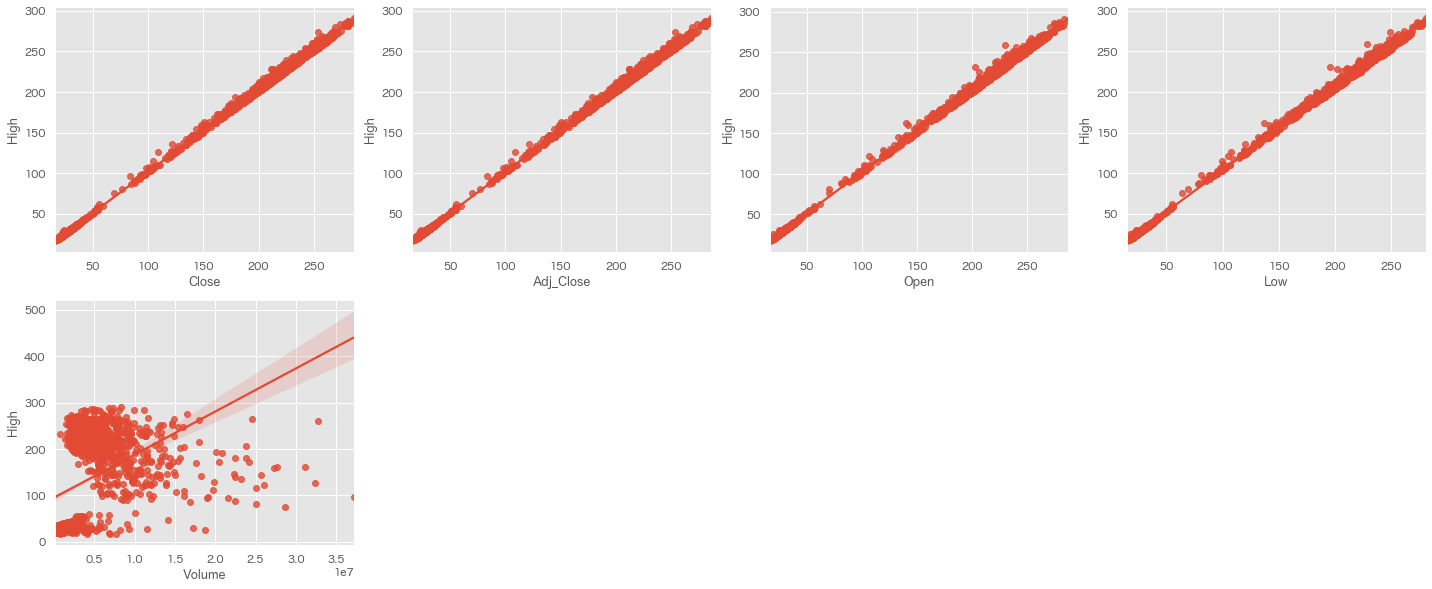

In [13]:
tgt = 'High' # 目的変数（高値とした場合）
data = stock_df
target_relation(tgt, data)

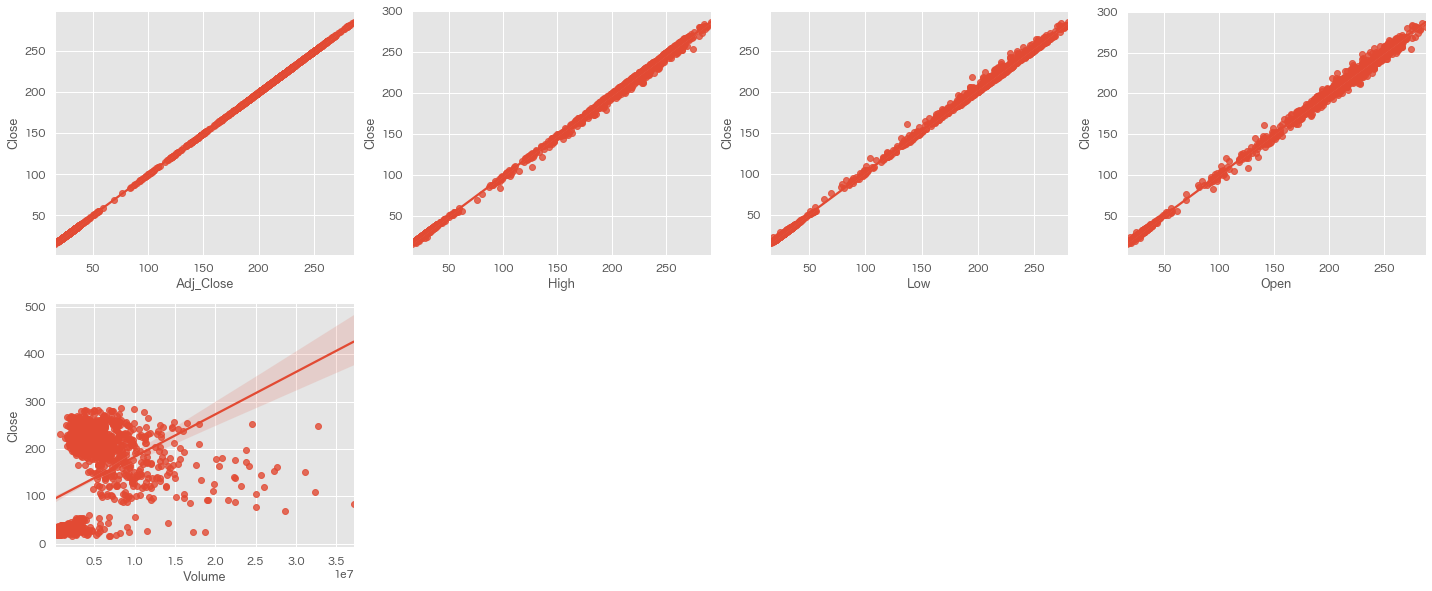

In [14]:
tgt = 'Close' # 目的変数（終わり値とした場合）
data = stock_df
target_relation(tgt, data)

Volume(取引量)は線形分離不可

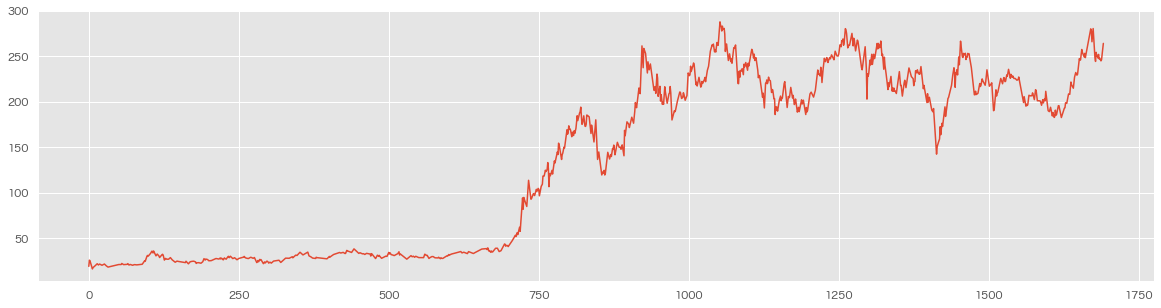

In [15]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Open']);

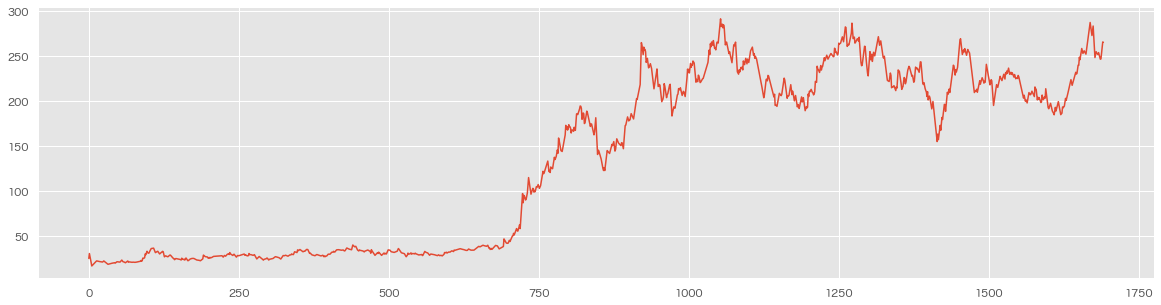

In [16]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['High']);

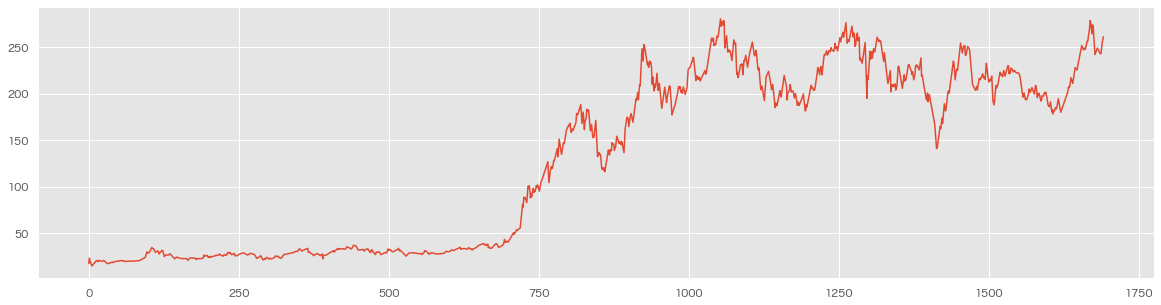

In [17]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Low']);

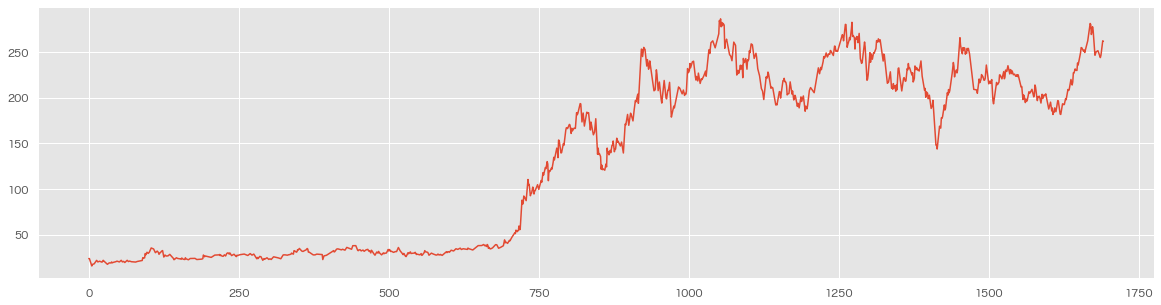

In [18]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Close']);

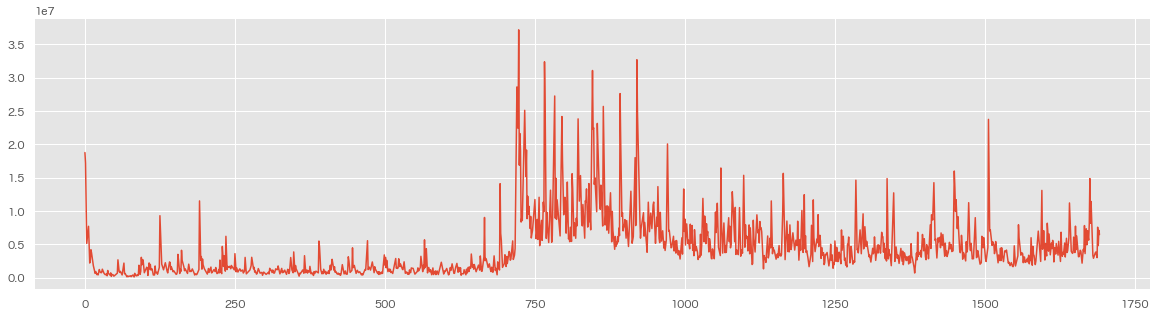

In [19]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Volume']);

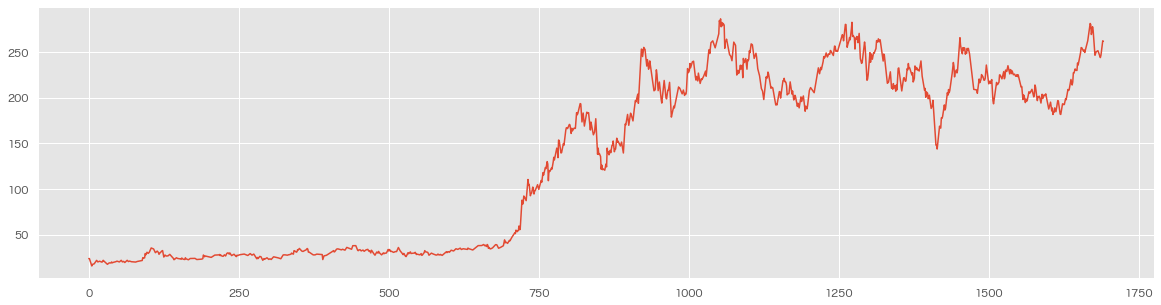

In [20]:
plt.figure(figsize=[20,5])
plt.plot(stock_df['Adj_Close']);

変換前の状態

# データ準備

In [21]:
# Dataをインデックスに設定
time_series = stock_df.copy()
time_series["Date"] = pd.to_datetime(stock_df['Date'])
time_series = time_series.set_index(['Date']).sort_index(ascending=True)
time_series.head()
time_series.tail()

Open  High  Low  Close    Volume  Adj_Close
Date                                                   
2010-06-29    19    25   18     24  18766300         24
2010-06-30    26    30   23     24  17187100         24
2010-07-01    25    26   20     22   8218800         22
2010-07-02    23    23   19     19   5139800         19
2010-07-06    20    20   16     16   6866900         16

Open  High  Low  Close   Volume  Adj_Close
Date                                                  
2017-03-13   245   247  243    246  3010700        246
2017-03-14   246   258  246    258  7575500        258
2017-03-15   257   261  254    256  4816600        256
2017-03-16   262   266  259    262  7100400        262
2017-03-17   264   265  261    262  6475900        262

# ADF検定（定常性の確認）

帰無仮説：単位根課程  
対立仮設：定常過程  
P値が0.05以下の場合、帰無仮説が棄却し、定常過程を正とする。  

In [22]:
from statsmodels.tsa import stattools

def adf_test(cicle):
    features = [time_series.columns]
    adf_df = pd.DataFrame(
        [
            stattools.adfuller(time_series.resample('M')[features[0][0]].sum())[1],
            stattools.adfuller(time_series.resample('M')[features[0][1]].sum())[1],
            stattools.adfuller(time_series.resample('M')[features[0][2]].sum())[1],
            stattools.adfuller(time_series.resample('M')[features[0][3]].sum())[1],
            stattools.adfuller(time_series.resample('M')[features[0][4]].sum())[1],
            stattools.adfuller(time_series.resample('M')[features[0][5]].sum())[1],
        ],
        index=features,
        columns=['P値']
    )
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

In [23]:
adf_test(cicle = 'D')

              P値
Open       0.529
High       0.533
Low         0.53
Close      0.533
Volume      0.29
Adj_Close  0.533


In [24]:
adf_test(cicle = 'M')

              P値
Open       0.529
High       0.533
Low         0.53
Close      0.533
Volume      0.29
Adj_Close  0.533


In [25]:
adf_test(cicle = 'Y')

              P値
Open       0.529
High       0.533
Low         0.53
Close      0.533
Volume      0.29
Adj_Close  0.533


# 前処理

## 差分変換

トレンドを除去し、平均における非定常性を解消

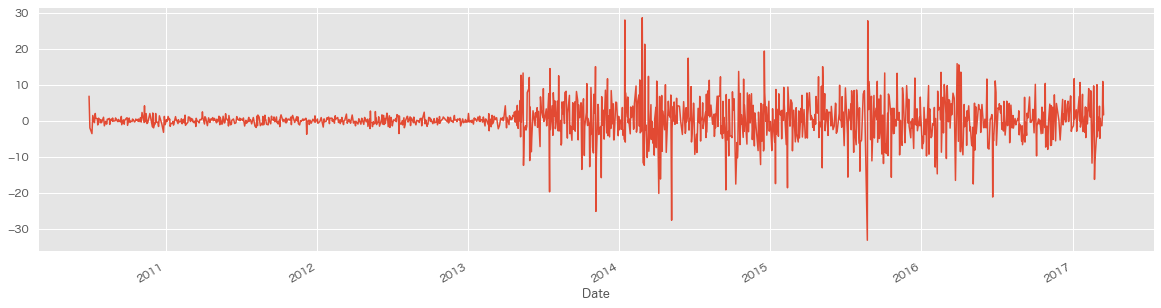

In [26]:
time_proc = time_series.copy()

Passengers_diff_o = time_proc["Open"].diff(periods = 1)
Passengers_diff_o.plot(figsize=[20,5]);

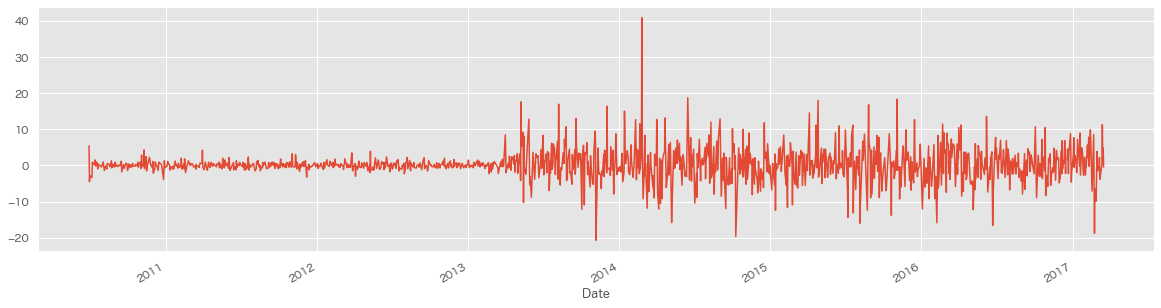

In [27]:
Passengers_diff_h = time_proc["High"].diff(periods = 1)
Passengers_diff_h.plot(figsize=[20,5]);

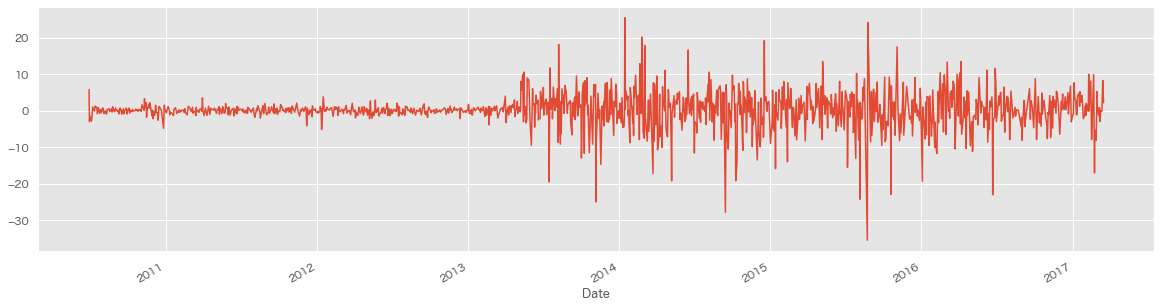

In [28]:
Passengers_diff_l = time_proc["Low"].diff(periods = 1)
Passengers_diff_l.plot(figsize=[20,5]);

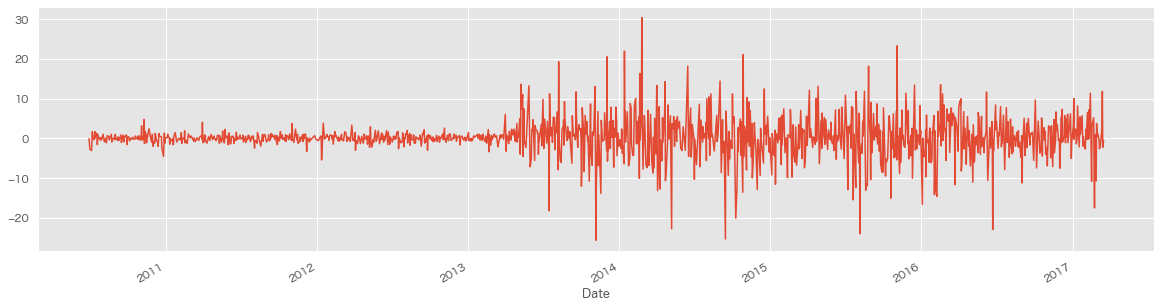

In [29]:
Passengers_diff_c = time_proc["Close"].diff(periods = 1)
Passengers_diff_c.plot(figsize=[20,5]);

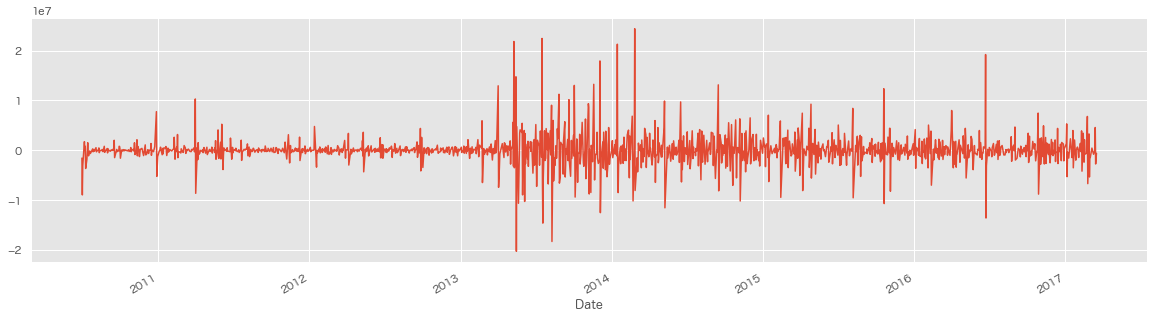

In [139]:
Passengers_diff_v = time_proc["Volume"].diff(periods = 1)
Passengers_diff_v.plot(figsize=[20,5]);

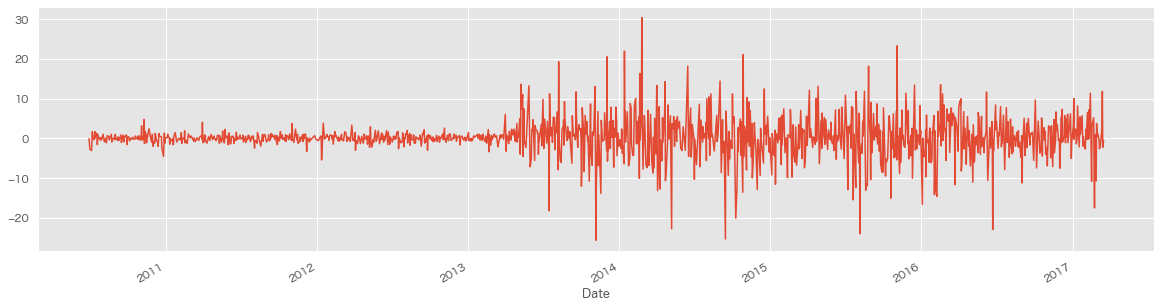

In [30]:
Passengers_diff_a = time_proc["Adj_Close"].diff(periods = 1)
Passengers_diff_a.plot(figsize=[20,5]);

## 対数変換

トレンドに比例したばらつきの増加を解消

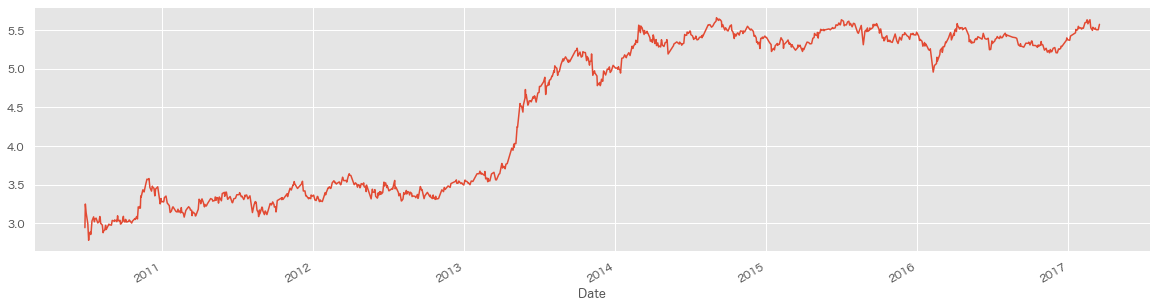

In [31]:
Passengers_log_o = np.log(time_proc["Open"])
Passengers_log_o.plot(figsize=[20,5]);

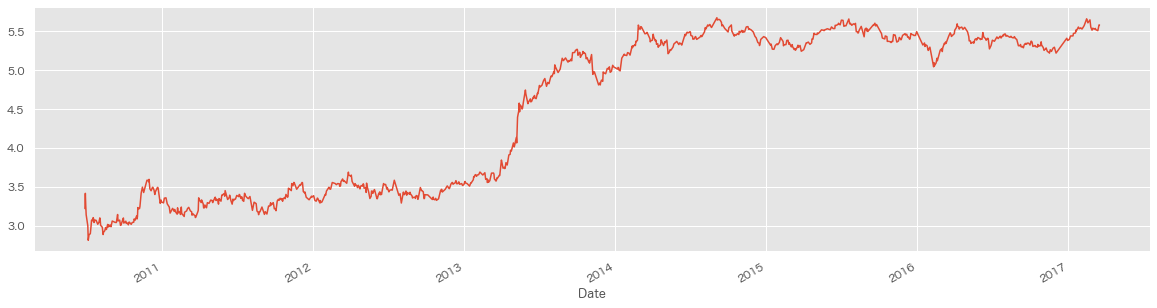

In [32]:
Passengers_log_h = np.log(time_proc["High"])
Passengers_log_h.plot(figsize=[20,5]);

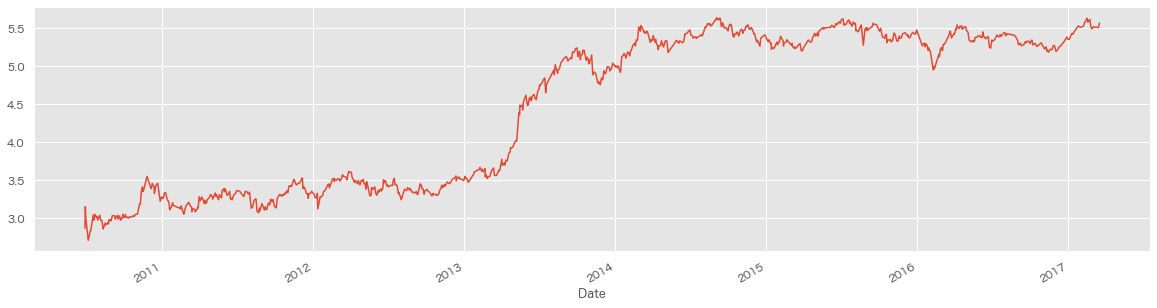

In [33]:
Passengers_log_l = np.log(time_proc["Low"])
Passengers_log_l.plot(figsize=[20,5]);

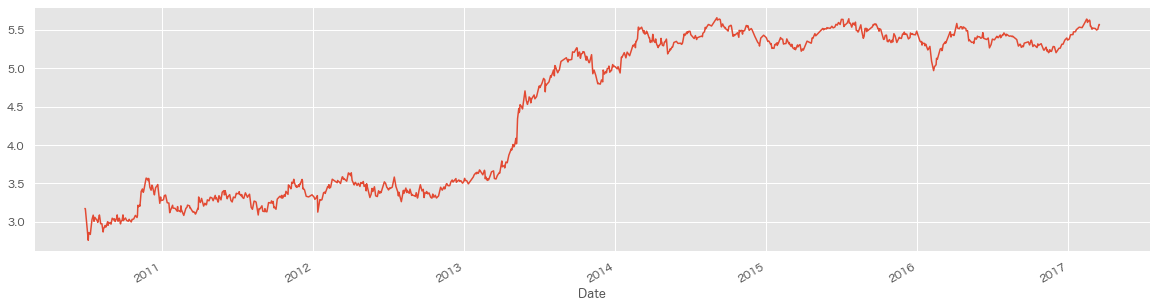

In [34]:
Passengers_log_c = np.log(time_proc["Close"])
Passengers_log_c.plot(figsize=[20,5]);

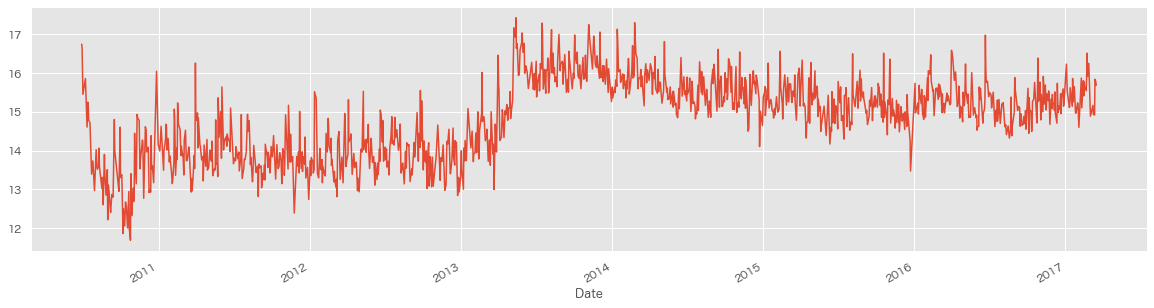

In [140]:
Passengers_log_v = np.log(time_proc["Volume"])
Passengers_log_v.plot(figsize=[20,5]);

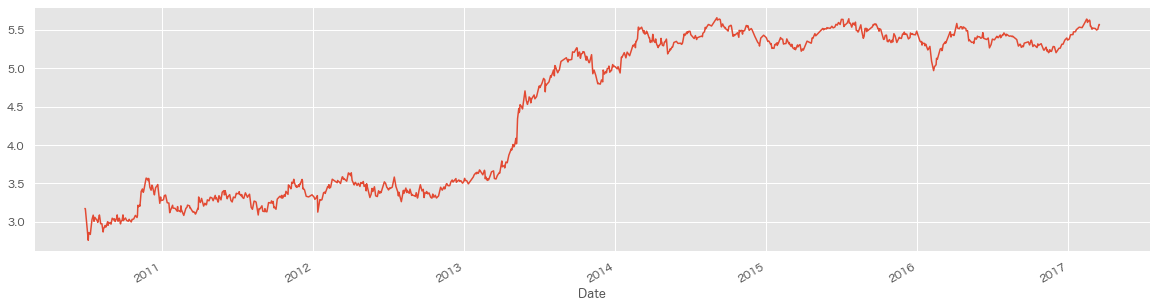

In [35]:
Passengers_log_a = np.log(time_proc["Adj_Close"])
Passengers_log_a.plot(figsize=[20,5]);

## 対数差分変換

周期性が残っているものの、定常性の条件のうち、平均と分散は解消

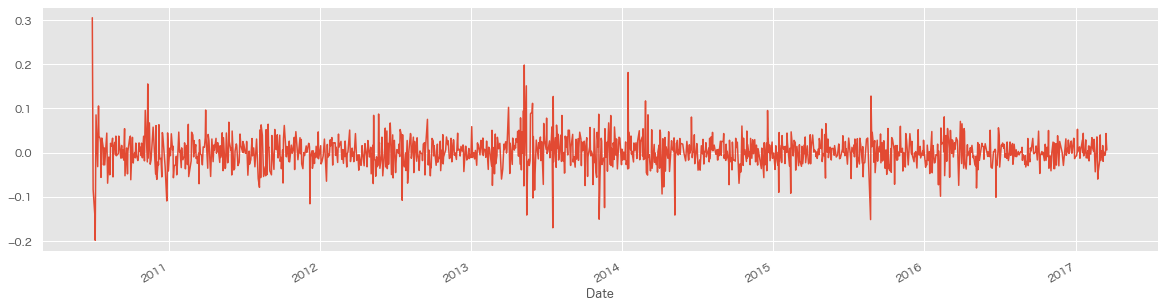

In [36]:
Passengers_log_diff_o = Passengers_log_o.diff(periods = 1)
Passengers_log_diff_o.plot(figsize=[20,5]);

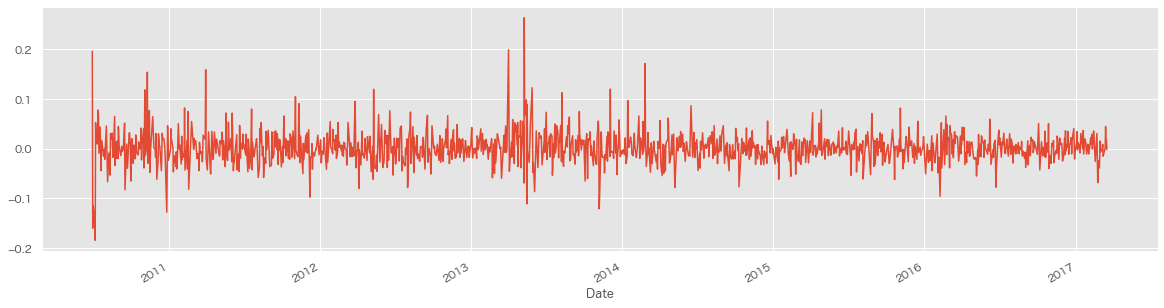

In [37]:
Passengers_log_diff_h = Passengers_log_h.diff(periods = 1)
Passengers_log_diff_h.plot(figsize=[20,5]);

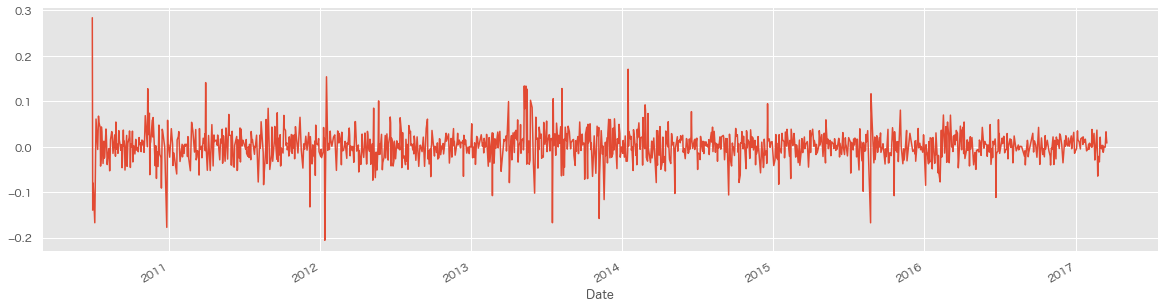

In [38]:
Passengers_log_diff_l = Passengers_log_l.diff(periods = 1)
Passengers_log_diff_l.plot(figsize=[20,5]);

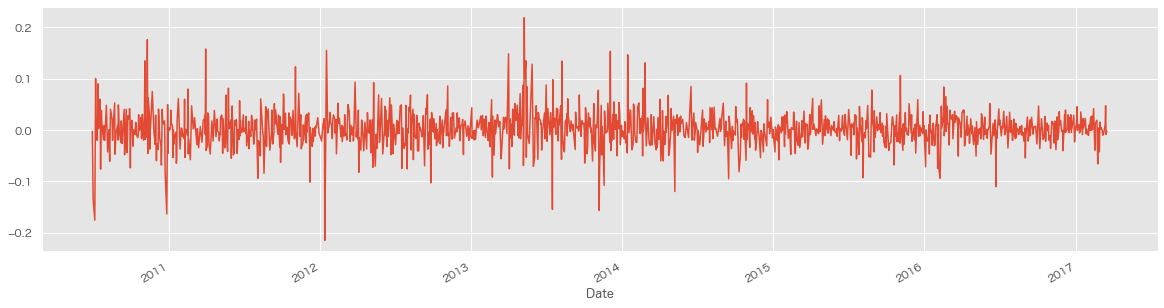

In [39]:
Passengers_log_diff_c = Passengers_log_c.diff(periods = 1)
Passengers_log_diff_c.plot(figsize=[20,5]);

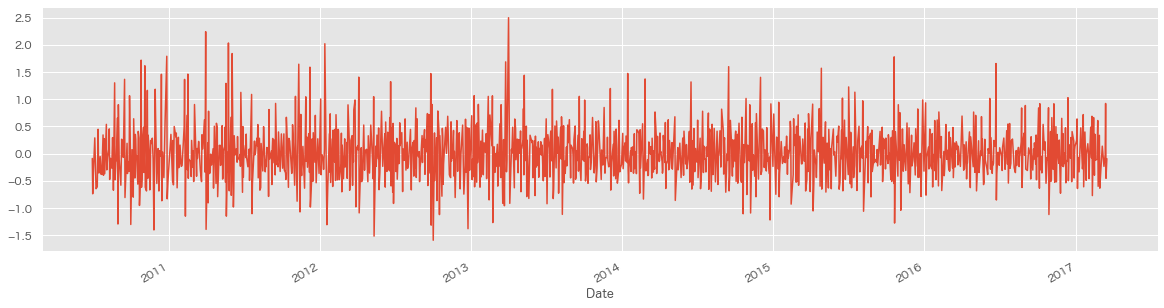

In [141]:
Passengers_log_diff_v = Passengers_log_v.diff(periods = 1)
Passengers_log_diff_v.plot(figsize=[20,5]);

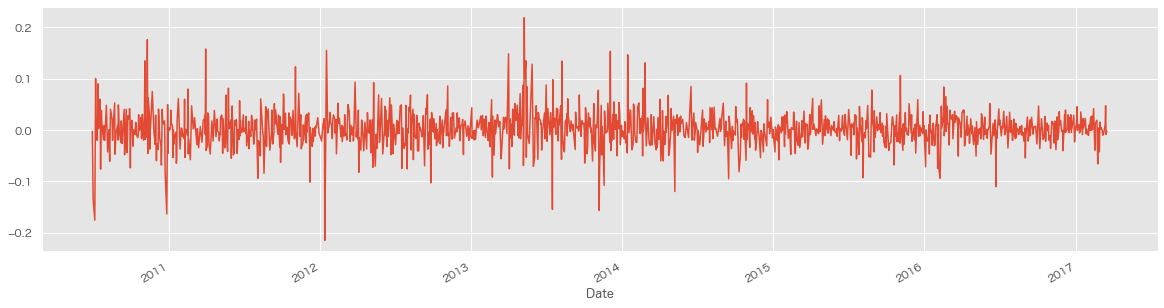

In [40]:
Passengers_log_diff_a = Passengers_log_a.diff(periods = 1)
Passengers_log_diff_a.plot(figsize=[20,5]);

## 季節差分変換

周期性を取り除く。季節周期がなくなり、前年差が残る

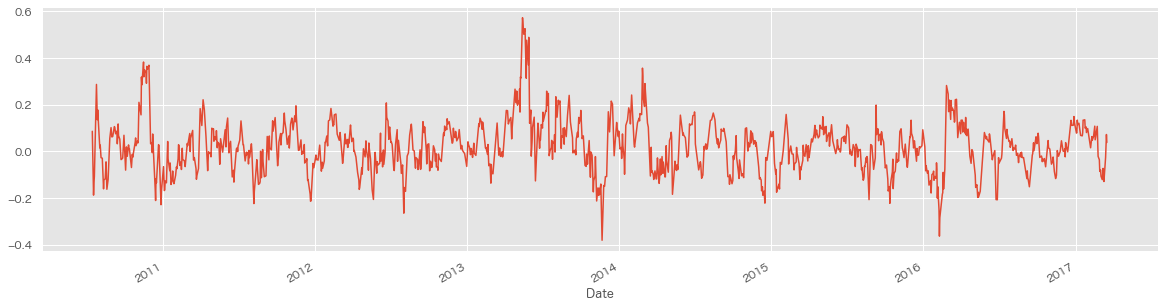

In [41]:
Passengers_sdiff_o = Passengers_log_o.diff(periods = 12)
Passengers_sdiff_o.plot(figsize=[20,5]);

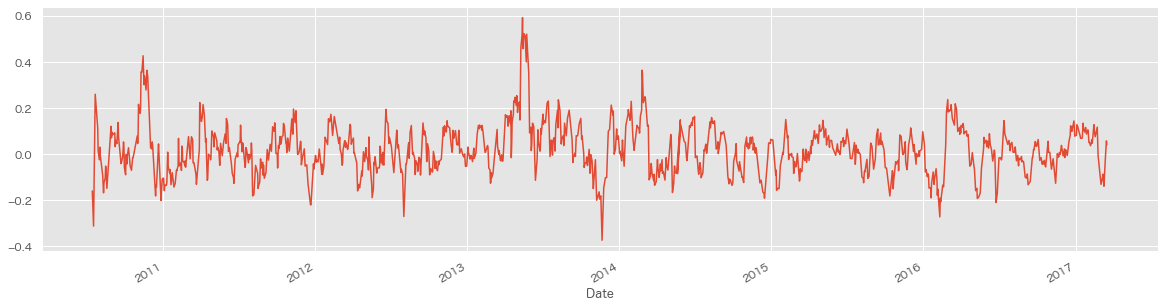

In [42]:
Passengers_sdiff_h = Passengers_log_h.diff(periods = 12)
Passengers_sdiff_h.plot(figsize=[20,5]);

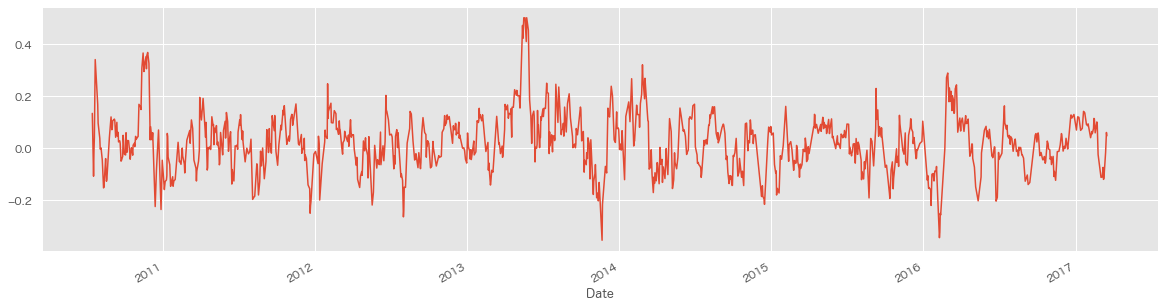

In [43]:
Passengers_sdiff_l = Passengers_log_l.diff(periods = 12)
Passengers_sdiff_l.plot(figsize=[20,5]);

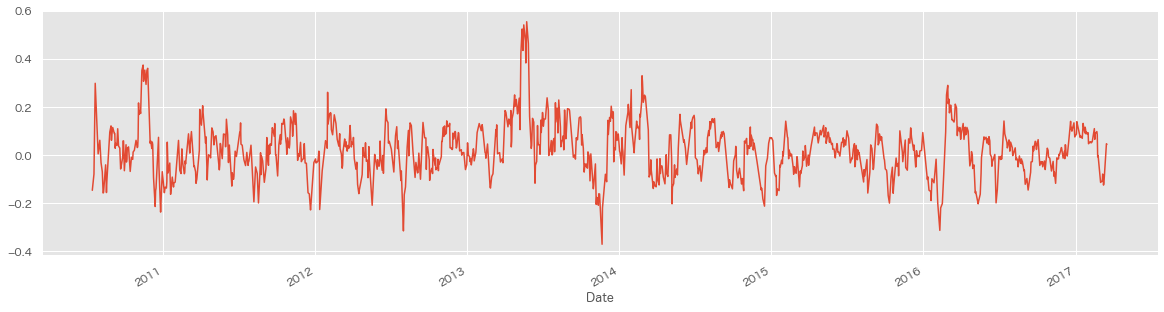

In [44]:
Passengers_sdiff_c = Passengers_log_c.diff(periods = 12)
Passengers_sdiff_c.plot(figsize=[20,5]);

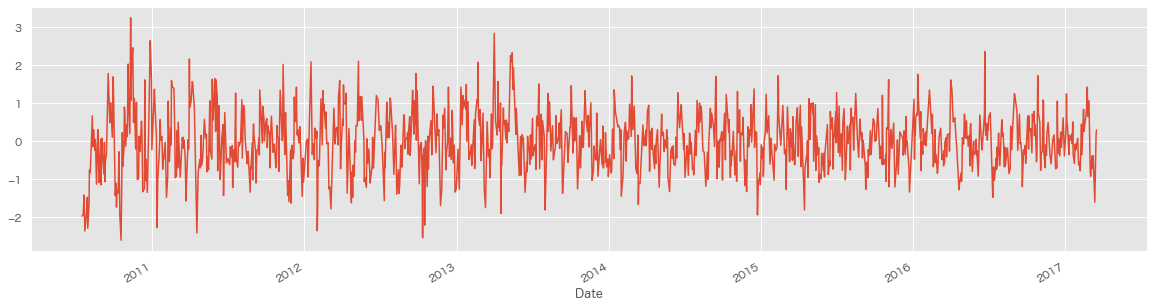

In [142]:
Passengers_sdiff_v = Passengers_log_v.diff(periods = 12)
Passengers_sdiff_v.plot(figsize=[20,5]);

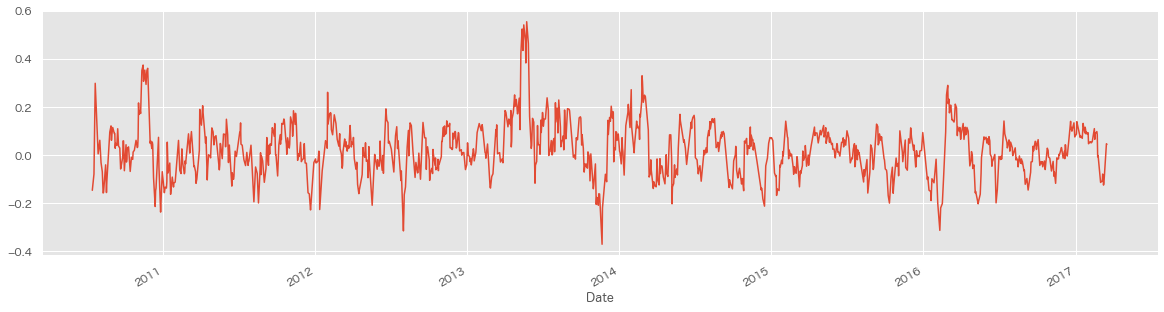

In [45]:
Passengers_sdiff_a = Passengers_log_a.diff(periods = 12)
Passengers_sdiff_a.plot(figsize=[20,5]);

## ラグ1の差分を取る

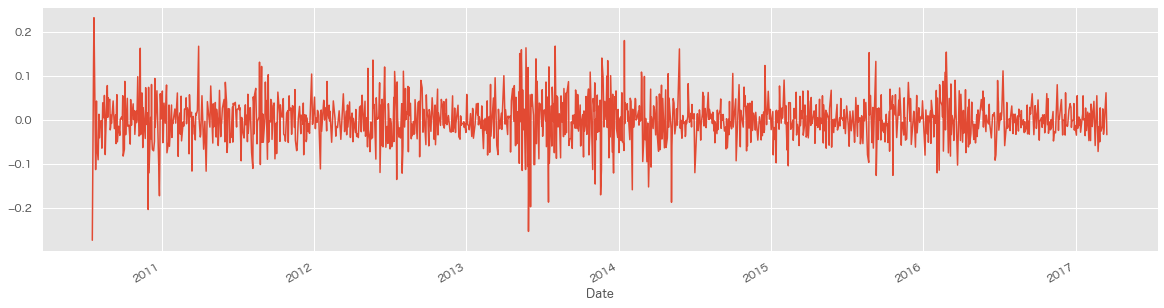

In [46]:
Passengers_sdiff2_o = Passengers_sdiff_o.diff()
Passengers_sdiff2_o.plot(figsize=[20,5]);

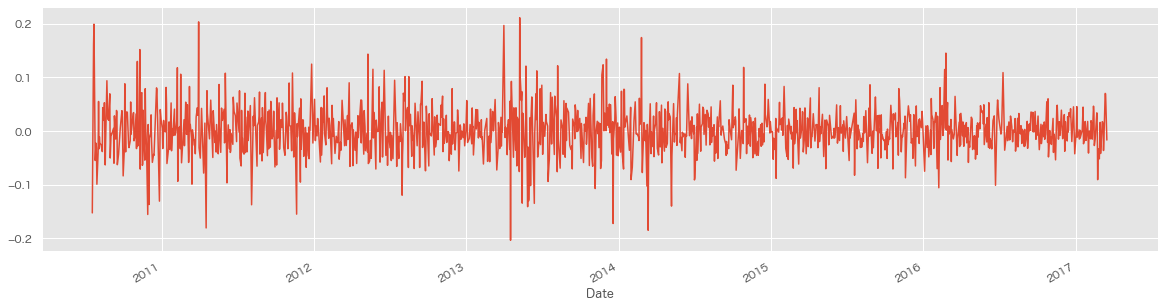

In [47]:
Passengers_sdiff2_h = Passengers_sdiff_h.diff()
Passengers_sdiff2_h.plot(figsize=[20,5]);

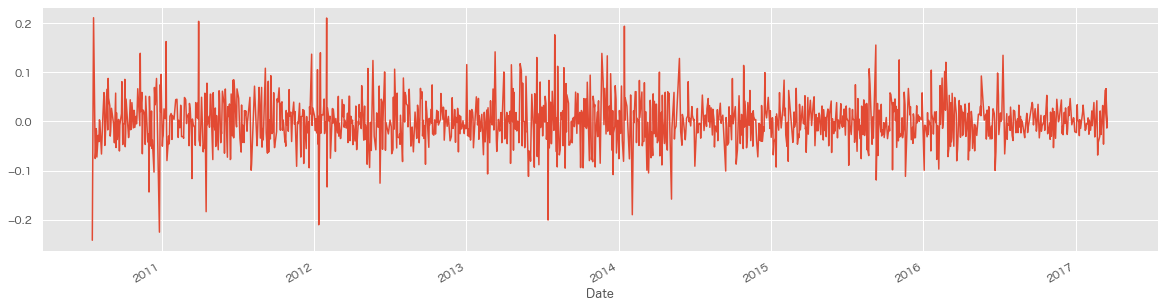

In [48]:
Passengers_sdiff2_l = Passengers_sdiff_l.diff()
Passengers_sdiff2_l.plot(figsize=[20,5]);

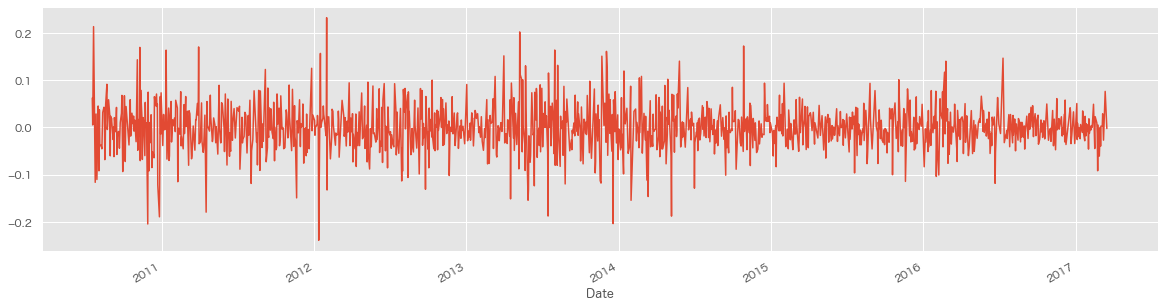

In [49]:
Passengers_sdiff2_c = Passengers_sdiff_c.diff()
Passengers_sdiff2_c.plot(figsize=[20,5]);

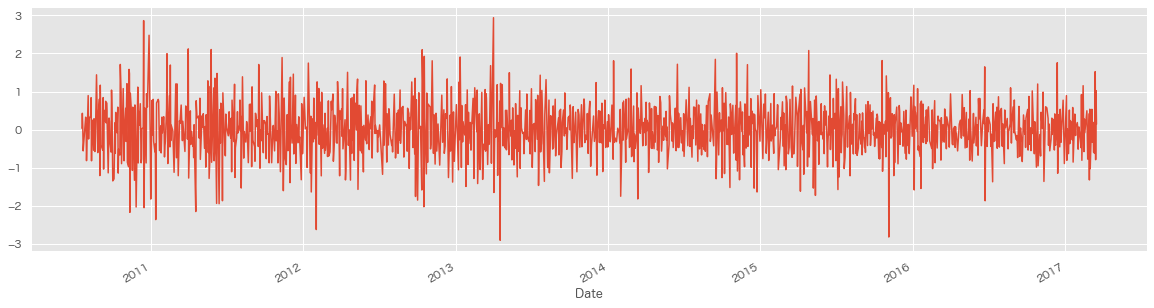

In [143]:
Passengers_sdiff2_v = Passengers_sdiff_v.diff()
Passengers_sdiff2_v.plot(figsize=[20,5]);

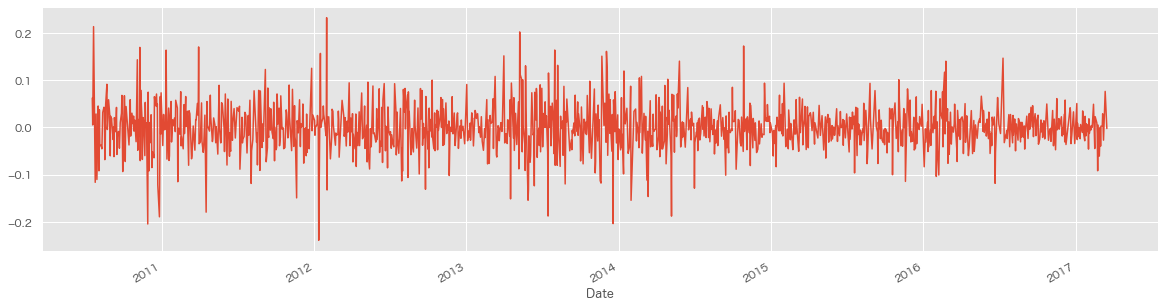

In [68]:
Passengers_sdiff2_a = Passengers_sdiff_a.diff()
Passengers_sdiff2_a.plot(figsize=[20,5]);

どのような性質をもつ系列であれば、差分変換が適切か  
単位根過程：「原系列が非定常であり、その差分系列が定常であるような時系列」、つまり「和分過程」であれば適切  

# 周期生の分析

## 成分分解

Trend：周期の長さで移動平均を求め、トレンド成分を求める  
Seasonal：トレンド除去後の時系列から季節性の成分を求める  
Resid：残差を求める  

In [51]:
# 成分分解
import statsmodels.api as sm

# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,15]
plt.rcParams["font.size"] = 15

# 原系列、傾向（トレンド）、周期変動（季節性）、不規則変動（残差）
def plt_seasonal_decompose(df, col_name, period):
    res = sm.tsa.seasonal_decompose(df[col_name], period=period)
    fig = res.plot()
    plt.show()

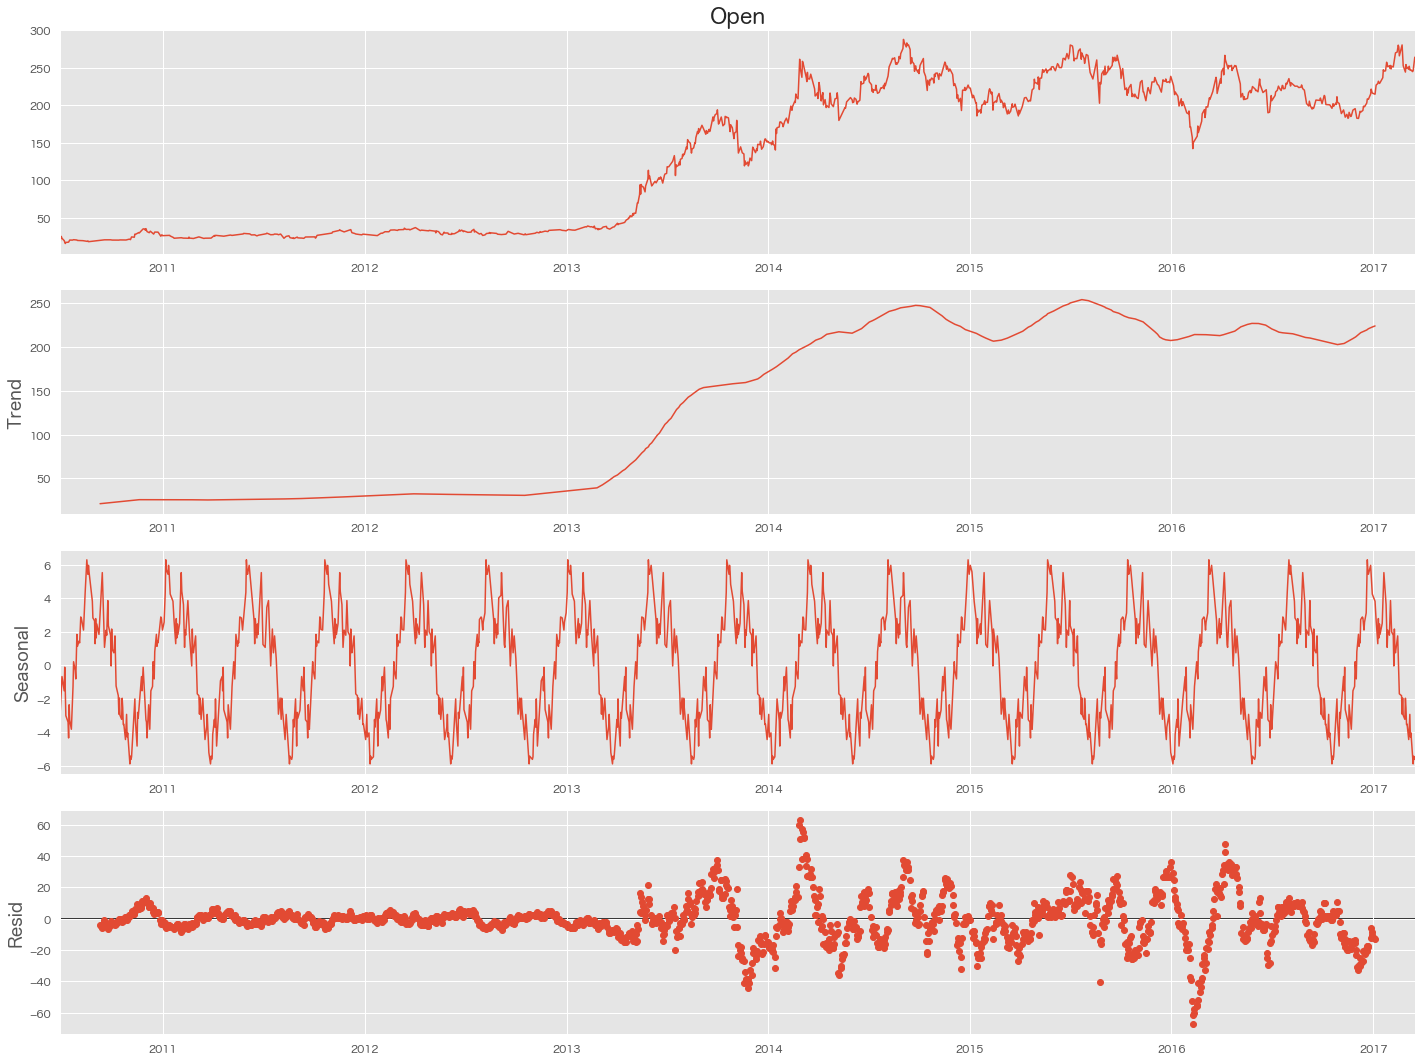

In [52]:
# 原系列をインプットして確認
plt_seasonal_decompose(time_series, col_name='Open', period=100)

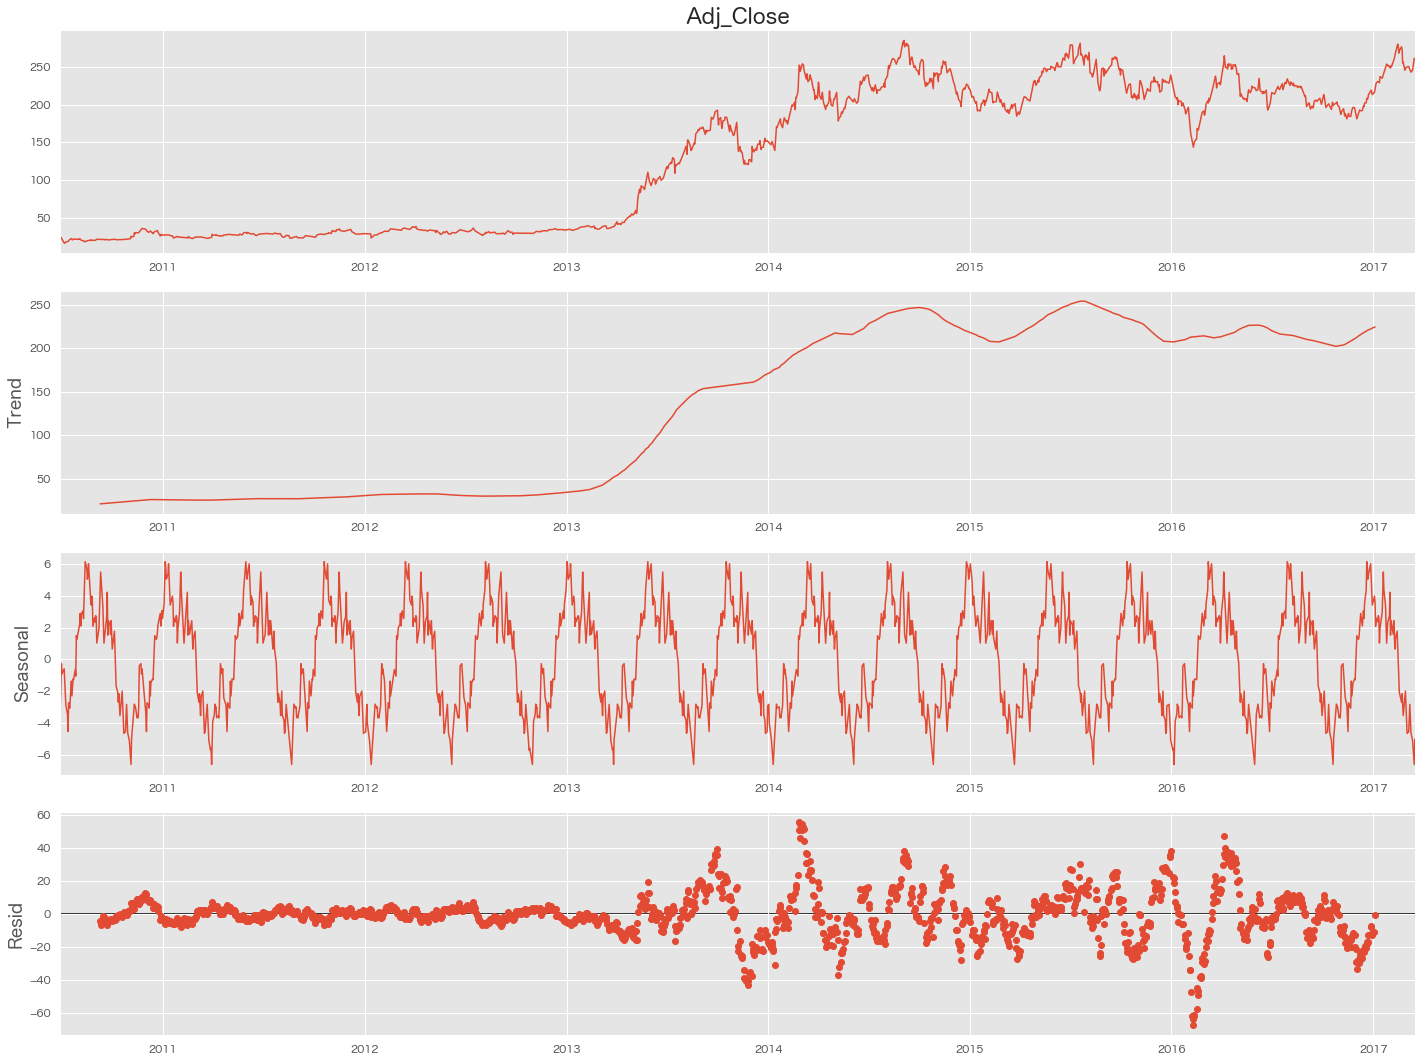

In [53]:
plt_seasonal_decompose(time_series, col_name='Adj_Close', period=100)

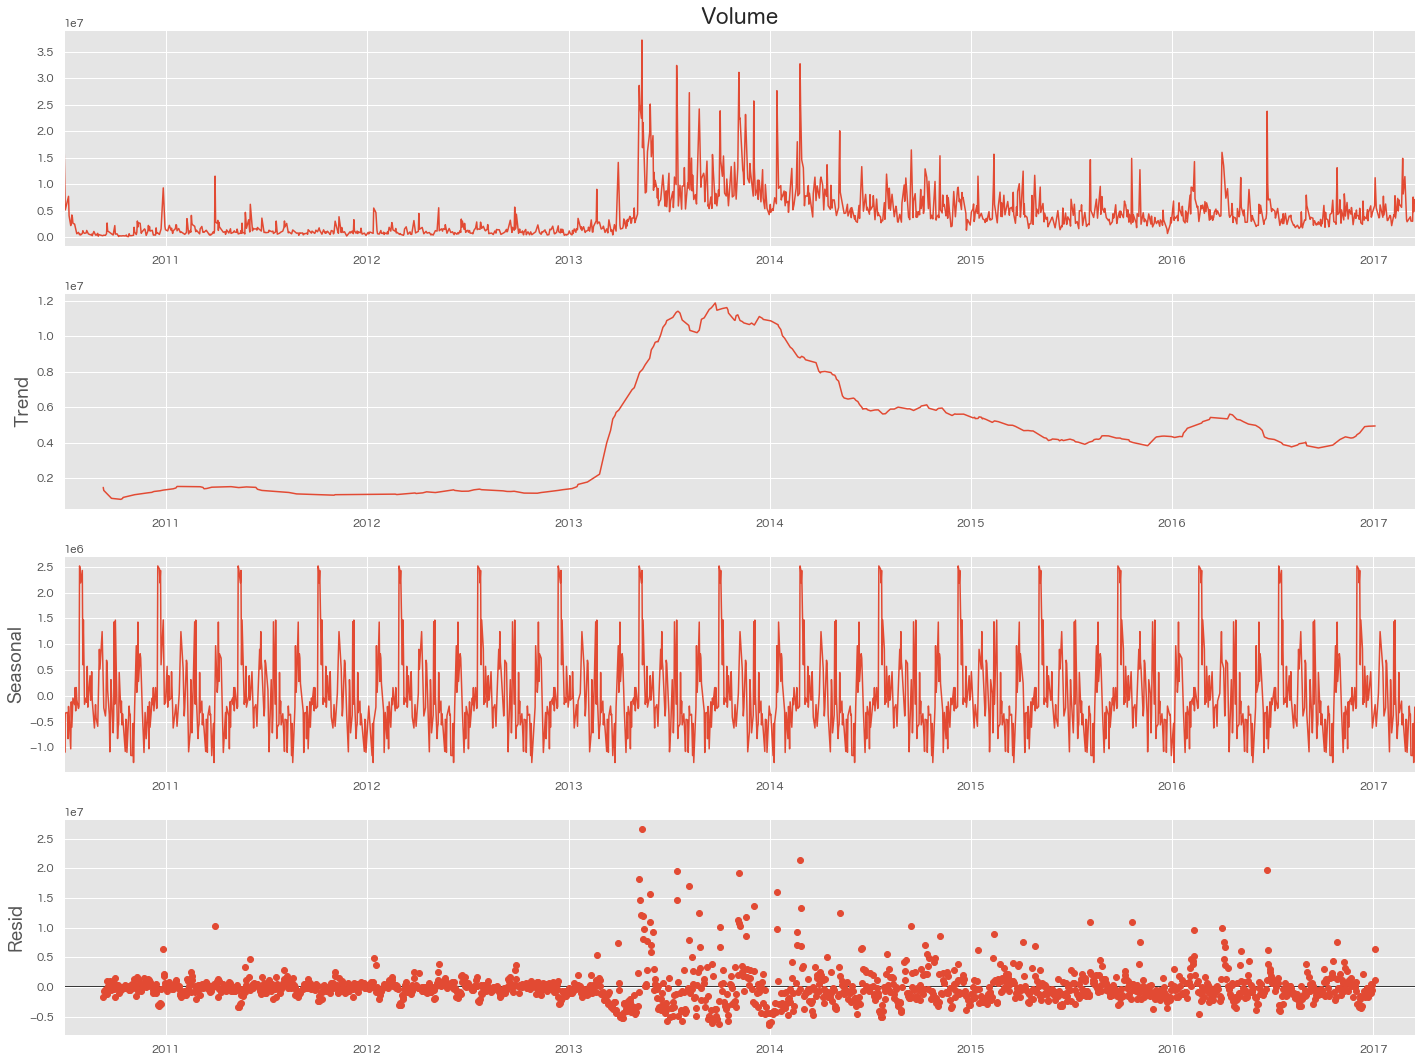

In [54]:
plt_seasonal_decompose(time_series, col_name='Volume', period=100)

## コレログラム

In [55]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,2]
plt.rcParams["font.size"] = 10

# コレログラム
def correlogram(cicle, lags):
    features = time_series.columns
    for feature in features:
        sm.graphics.tsa.plot_acf(time_series.resample(cicle)[feature].sum(), title=feature, lags=lags)

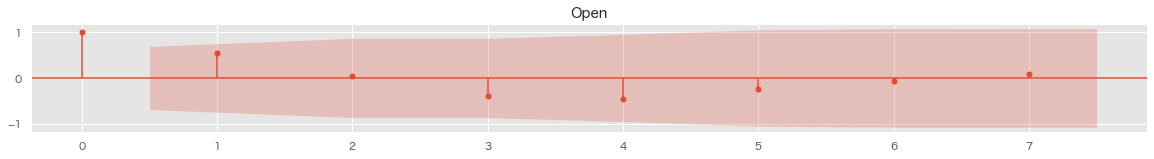

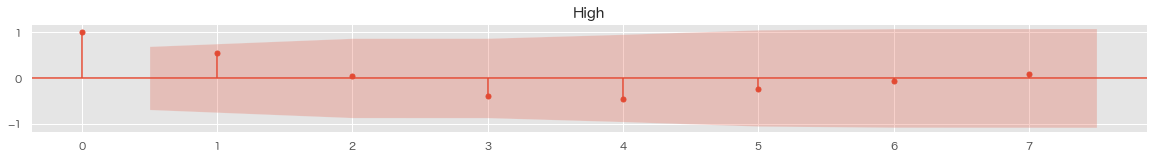

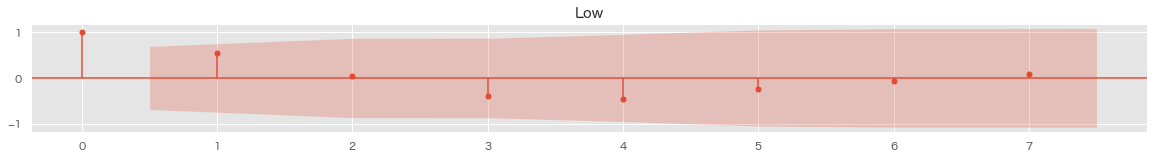

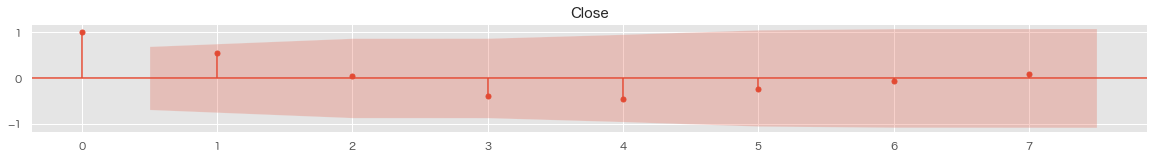

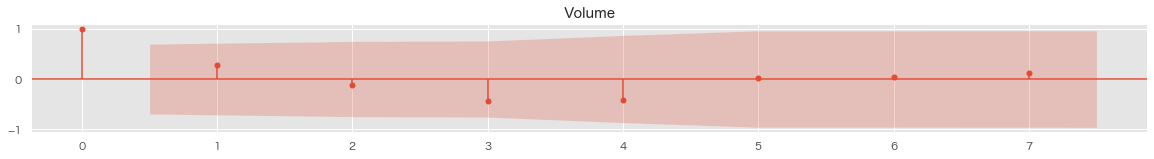

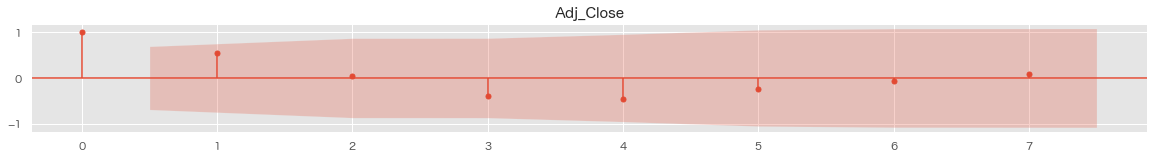

In [56]:
# まずは原系列をインプットして確認
correlogram(cicle='Y', lags='7')

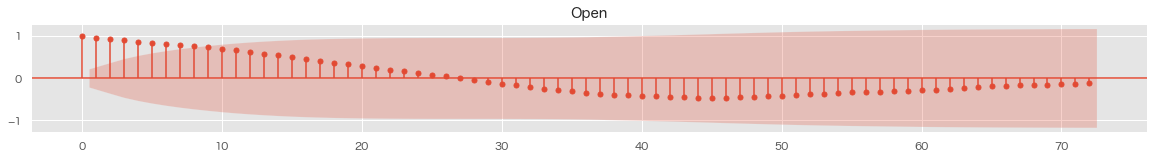

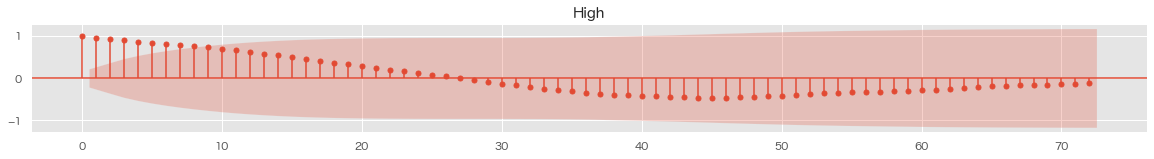

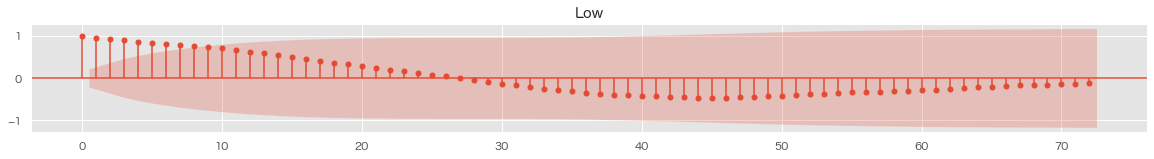

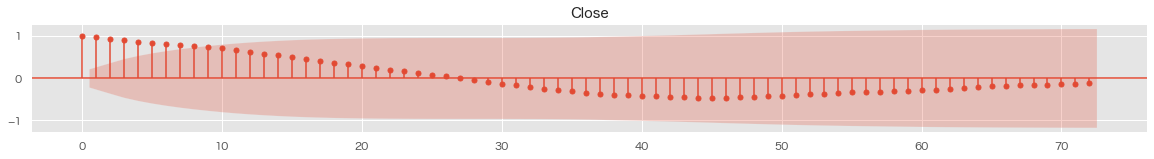

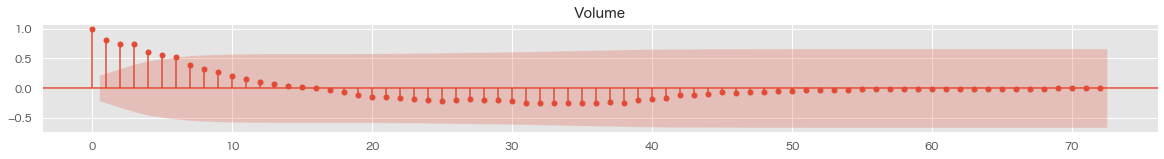

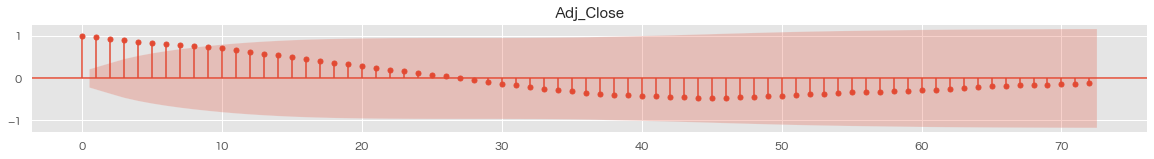

In [57]:
correlogram(cicle='M', lags=str(12*6))

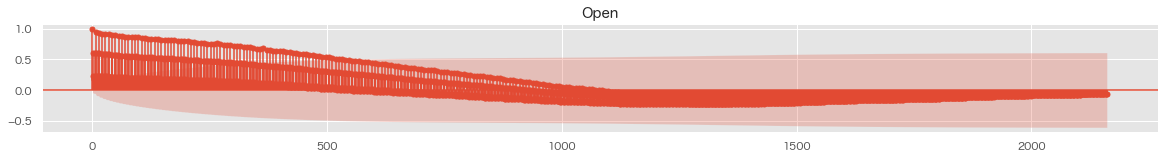

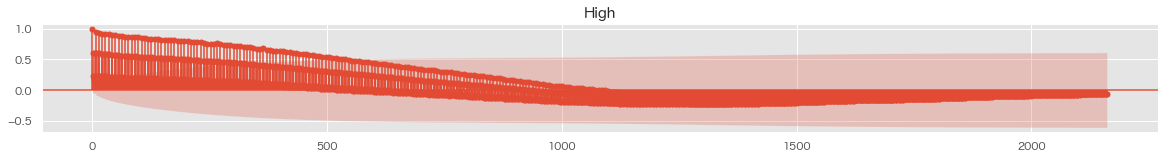

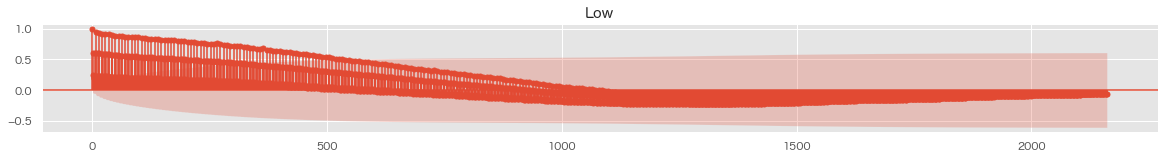

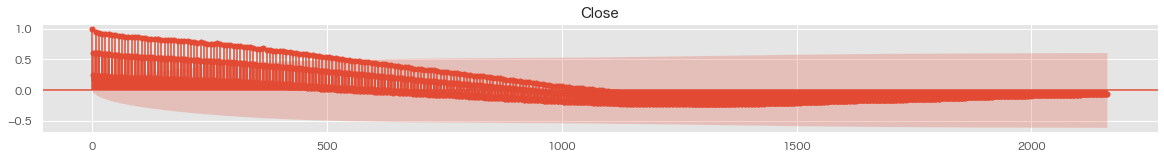

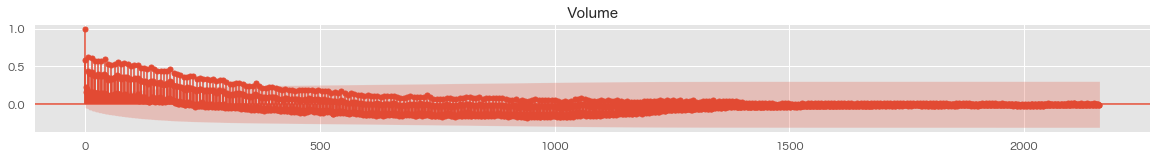

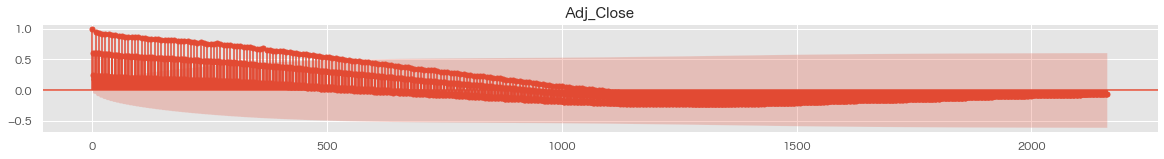

In [58]:
correlogram(cicle='D', lags=str(30*12*6))

# 前処理後のデータで再確認

In [165]:
# 欠損の削除
Passengers_sdiff_a2 = Passengers_sdiff_a.dropna()

# ADF検定
adf_df = pd.DataFrame(
    [
        stattools.adfuller(Passengers_sdiff_a2.resample('Y').sum())[1]
    ],
    columns=['P値']
)
adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
print(adf_df)

      P値
0  0.231


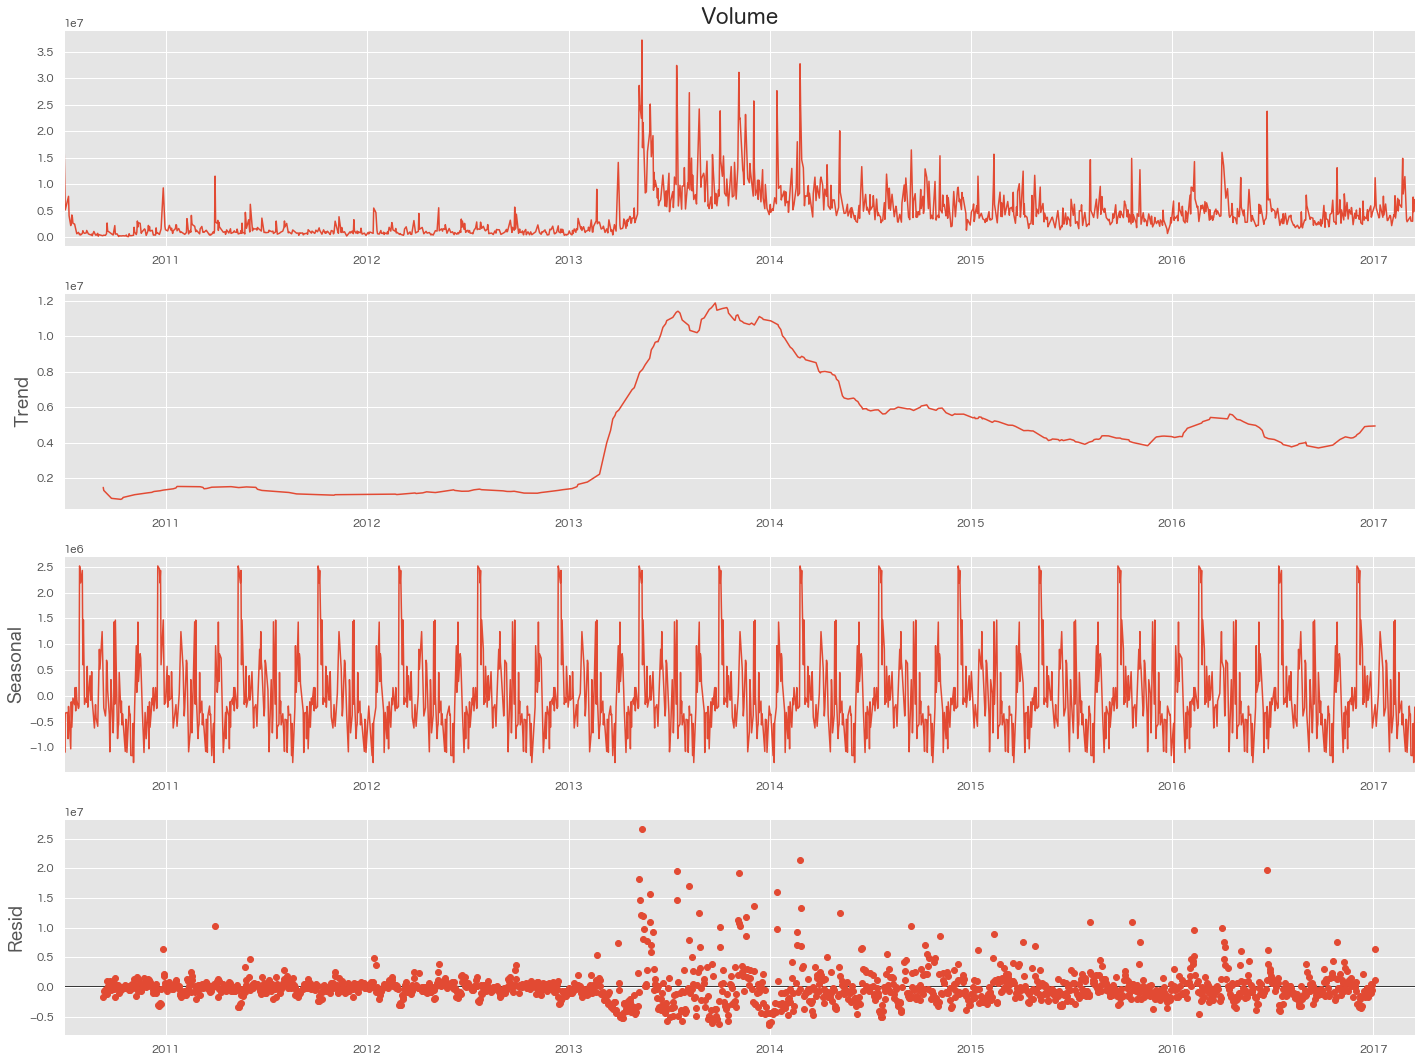

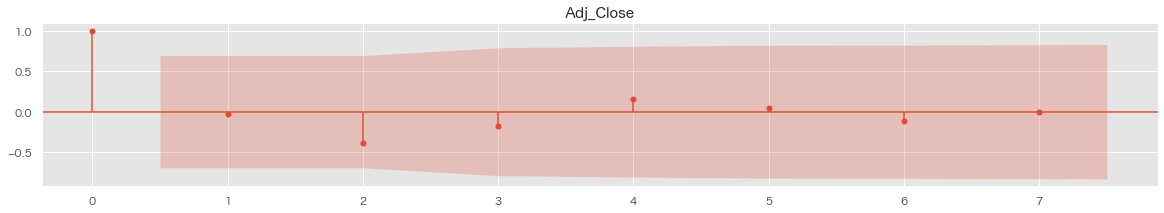

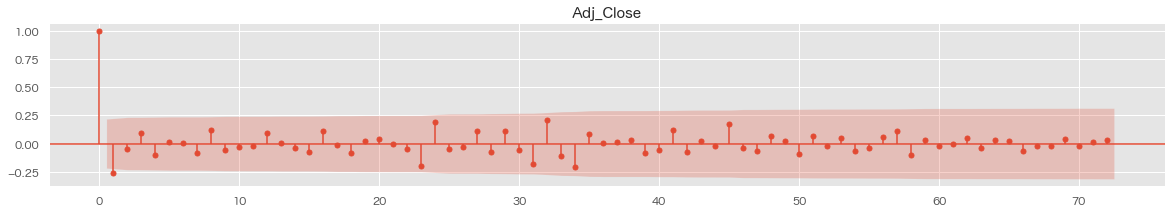

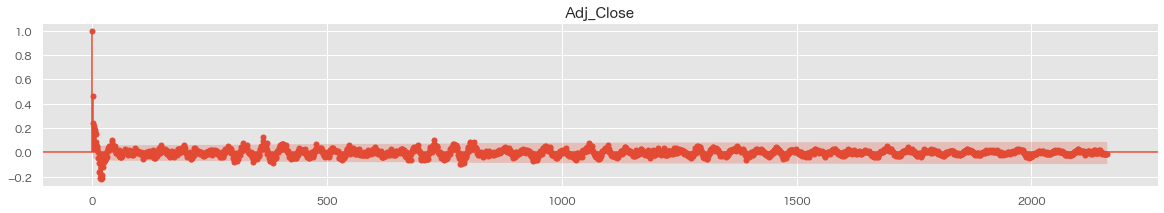

In [157]:
plt.rcParams["figure.figsize"] = [20,15]
plt.rcParams["font.size"] = 15
# 原系列をインプット
res = sm.tsa.seasonal_decompose(time_proc["Volume"], period=100)
fig = res.plot()
plt.show()

# コレログラム
# 季節調整後のデータをインプット
plt.rcParams["figure.figsize"] = [20,3]
plt.rcParams["font.size"] = 10
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2.resample('Y').sum(), title='Adj_Close', lags=7)
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2.resample('M').sum(), title='Adj_Close', lags=str(12*6))
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2.resample('D').sum(), title='Adj_Close', lags=str(30*12*6));

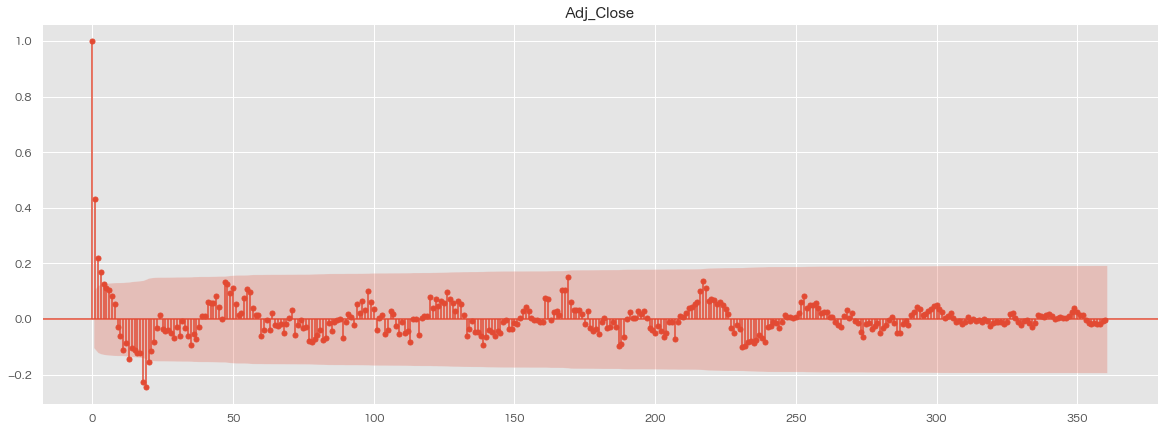

In [158]:
plt.rcParams["figure.figsize"] = [20,7]

# 2011年に絞る
Passengers_sdiff_a2_2011 = Passengers_sdiff_a2[ Passengers_sdiff_a2.index.astype(str).str[:4] == '2011' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2_2011.resample('D').sum(), title='Adj_Close', lags=str(30*12));

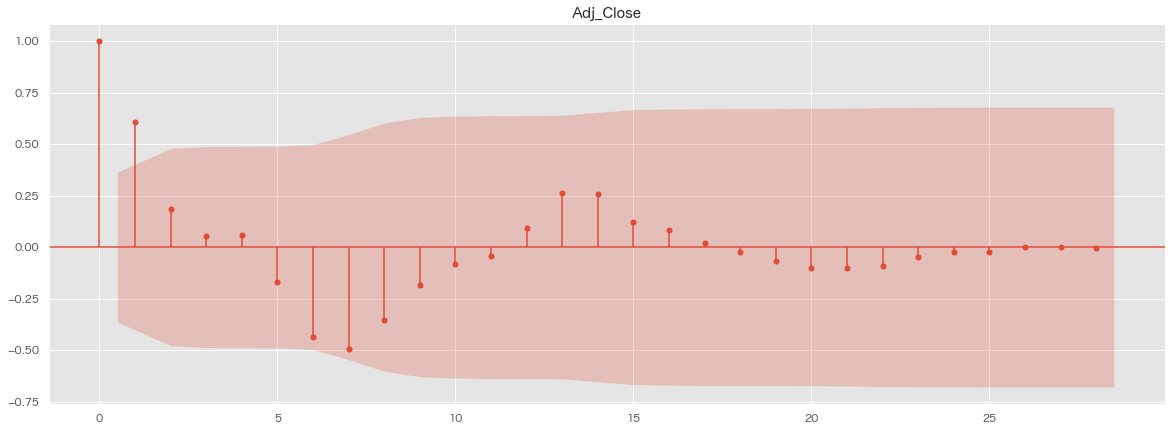

In [159]:
# 2011年の1月に絞る
Passengers_sdiff_a2_2011_1 = Passengers_sdiff_a2[ Passengers_sdiff_a2.index.astype(str).str[:7] == '2011-01' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2_2011_1.resample('D').sum(), title='Adj_Close', lags=str(28));

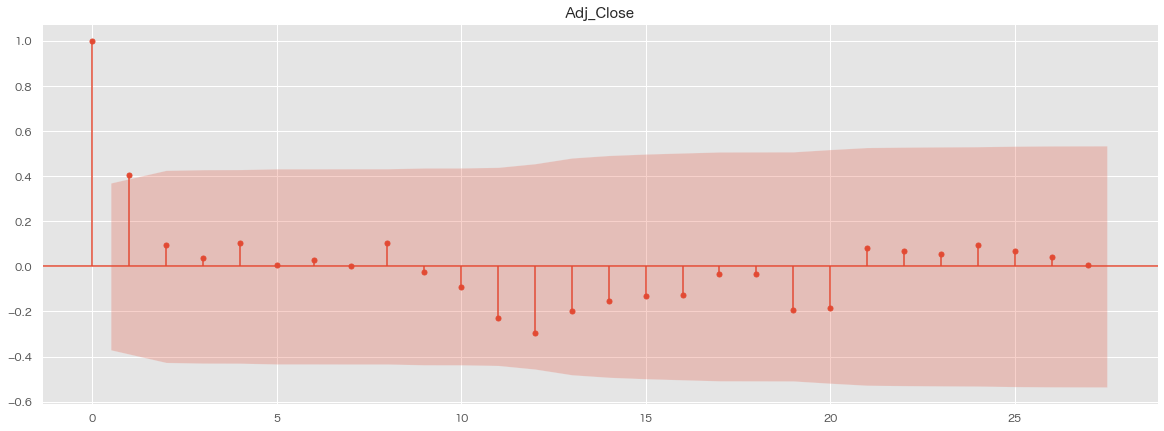

In [162]:
# 2011年の2月に絞る
Passengers_sdiff_a2_2011_2 = Passengers_sdiff_a2[ Passengers_sdiff_a2.index.astype(str).str[:7] == '2011-02' ].copy()
sm.graphics.tsa.plot_acf(Passengers_sdiff_a2_2011_2.resample('D').sum(), title='Adj_Close', lags=str(27));